# P4: Advanced Lane Lines

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.


* Apply a distortion correction to raw images.

* Use color transforms, gradients, etc., to create a thresholded binary image.


* Apply a perspective transform to rectify binary image ("birds-eye view").


* Detect lane pixels and fit to find the lane boundary.


* Determine the curvature of the lane and vehicle position with respect to center.


* Warp the detected lane boundaries back onto the original image.


* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

from scipy.signal import argrelmax
from scipy.signal import find_peaks_cwt

%matplotlib inline



## Camera Calibration and Distortion Correction

In [2]:
def calibrate_camera(cal_img, nx, ny):
    
    objpoints = [] #3D represntaion
    imgpoints = [] #2D pts From Image
    
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)
    
    for image in cal_images:
        
        img = mpimg.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        if(ret):
            objpoints.append(objp)
            imgpoints.append(corners)
        
        
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[:2],None,None)
    
    return mtx, dist

            
    

In [3]:
# Number of inner corners per row and column
nx, ny = 9, 6
cal_images = glob.glob('camera_cal/*.jpg')
#print(cal_images)
# Calibrate and find Camera Martix, Distortion coff
cam_mtx, cam_dist = calibrate_camera(cal_images, nx, ny)


In [4]:
def undistort(image):
    
    return cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)

## Example of Distortion corrected image

(720, 1280, 3)


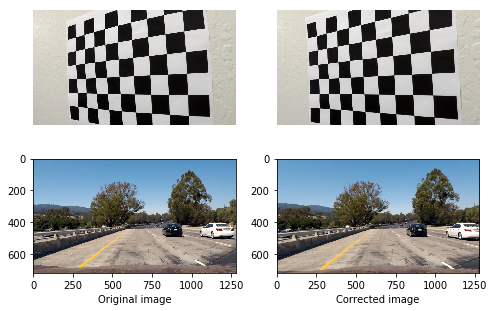

In [5]:
image = mpimg.imread('test_images/test1.jpg')
calibration_image = plt.imread("camera_cal/calibration4.jpg")
calibration_undimage = undistort(calibration_image)
undist_img = undistort(image)
plt.figure(figsize=(8,5))


plt.subplot(2, 2, 1)
plt.imshow(calibration_image)
plt.axis('off')
plt.xlabel('Original Calibration image')

plt.subplot(2, 2, 2)
plt.imshow(calibration_undimage)
plt.axis('off')
plt.xlabel('Corrected image')

plt.subplot(2, 2, 3)
plt.imshow(image)
#plt.axis('off')
plt.xlabel('Original image')

plt.subplot(2, 2, 4)
plt.imshow(undist_img)
#plt.axis('off')
plt.xlabel('Corrected image')

#image = undist_img

print(image.shape)

plt.show()

## Perspective Transform Example 

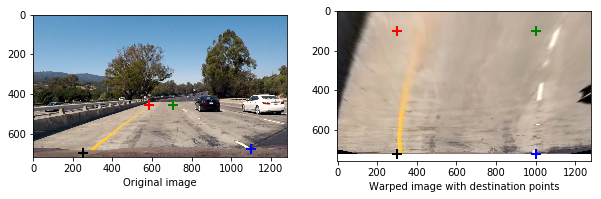

In [6]:

image_size = image.shape

src = np.array([[585, 455],
                [705, 455],
                [1100, 680],
                [250 , 700]], np.float32)

dst = np.array([[300 ,100],
                [1000, 100],
                [1000, 720],
                [300, 720]], np.float32)

warp_m = cv2.getPerspectiveTransform(src, dst)
warp_minv = cv2.getPerspectiveTransform(dst, src)    

colors = ['r+','g+','b+','k+']  

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
  
plt.imshow(image)
for i in range(4):
        plt.plot(src[i,0],src[i,1],colors[i],mew=2,ms=10)
        plt.xlabel('Original image')
        
img_w = cv2.warpPerspective(image, warp_m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
plt.subplot(1,2,2)
plt.imshow(img_w)

for i in range(4):
        plt.plot(dst[i,0],dst[i,1],colors[i],mew=2,ms=10)
        plt.xlabel('Warped image with destination points')
plt.show()

In [7]:
def gaussian_blur(img, kernel_size=5):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

## Thresholding

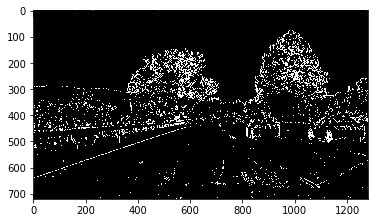

In [8]:
def abs_sobel_thresh(img, thresh_min=20, thresh_max=200):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

sobel_binary = abs_sobel_thresh(image)
plt.imshow(sobel_binary, cmap = 'gray')
plt.show()


## Color Thresholding in HLS 

In [9]:
def hls_binary(image, channel, thresh_min=170, thresh_max=255):    
    # Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # Extract the desired channel
    channel = hls[:,:,channel]
    
    # Apply the threshold
    channel_binary = np.zeros_like(channel)
    channel_binary[(channel >= thresh_min) & (channel <= thresh_max)] = 1
    
    return channel_binary    

## Lane color selection 

In [10]:
def select_color(image):
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    lower_yellow = np.array([10, 100, 100])
    upper_yellow = np.array([100,255,255])
    
    upper_white =np.array([220,220,220])
    lower_white = np.array([255,255,255])
    
    
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)    
    mask_white = cv2.inRange(image, upper_white, lower_white)
    
    # Bitwise-OR white and yellow mask
    mask = cv2.bitwise_or(mask_white, mask_yellow)


    return mask

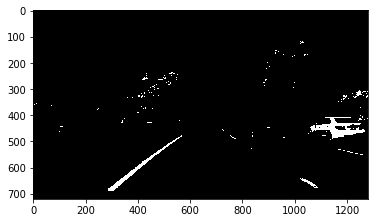

In [11]:
def binary_img(image):
    
    color_sel = select_color(image)
    
    sobel = abs_sobel_thresh(image)
    
    s_channel = hls_binary(image,2)

    l_channel = hls_binary(image,1 ,thresh_min=190)

    thresh=(130, 255)
    gray = np.zeros_like(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
    gray[(gray > thresh[0]) & (gray < thresh[1])] = 1
    
    combined_binary = np.zeros_like(s_channel)

    combined_binary[color_sel ==255 | ((s_channel == 1) & (l_channel == 1)) 
                   | ((sobel == 1) & (gray == 1)) | (l_channel == 1)] = 1
    
    return combined_binary

img = binary_img(image)
plt.imshow(img,cmap='gray')
plt.show()

## Lane region selection 

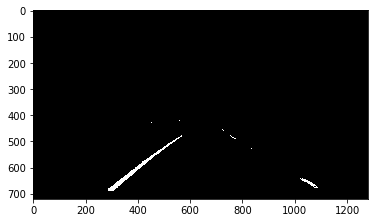

In [12]:
def ROI(image):
    
    top_left = (image.shape[1] * 0.4 , image.shape[0]/2)
    top_right = (image.shape[1] * 0.45 , image.shape[0]/1.95)

    bottom_left = (image.shape[1] * 0.15, image.shape[0])
    bottom_right = (image.shape[1] * 0.93, image.shape[0])
    
    mask = np.zeros_like(image)
    region = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
   
    
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, region , ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    
    return masked_image

img_filtered = binary_img(ROI(image))
plt.imshow(img_filtered,cmap='gray')
plt.show()

In [13]:
# Hough transform parameters
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 30     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 1 # minimum number of pixels making up a line
max_line_gap = 5    # maximum gap in pixels between connectable line segments

gaussian_kernel_size = 5

canny_low_threshold = 50
canny_high_threshold = 150


In [14]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), min_line_len,max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    lines = draw_lines(line_img, lines)
    return lines, line_img

In [15]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines function, An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [16]:
def get_blank_image(image):
    return np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

In [17]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=5):

    #Reshape from 3d to 2d array
    lines = lines.reshape(-1,lines.shape[2]) 
    #Calcualte Slopes
    slopes = (lines[:,3]-lines[:,1])/(lines[:,2]-lines[:,0])
    #remove garbage values 
    slopes = slopes[~np.isnan(slopes) & ~np.isinf(slopes)] 

    
    right_lines = np.array([])
    left_lines = np.array([])
    
    #Split lines in right and left based on slope and point position
    
    for x in range(len(slopes)): 
        x_center = img.shape[1]/2
        x1, y1, x2, y2 = lines[x] 
        if slopes[x] > 0 and x1 >x_center and x2>x_center:
            right_lines = np.append(right_lines,lines[x])
        elif slopes[x] < 0 and x1 <x_center and x2<x_center:
             left_lines = np.append(left_lines,lines[x])
    
    #List of coordinates
    right_lines = right_lines.reshape(-1,2)
    left_lines  = left_lines.reshape(-1,2)
    
    #Calculate best fit based on leniar regression
    
    if(len(right_lines[:,0])>0): #expected non-empty vector for x
        global right 
        right = np.poly1d(np.polyfit(right_lines[:,0], right_lines[:,1], 1)) # 0 1 leniar
    if(len(left_lines[:,0])>0):
        global left
        left  = np.poly1d(np.polyfit(left_lines[:,0] , left_lines[:,1] , 1))   
    
    #Define y endpoints 
    
    y1 = int(img.shape[0])
    y2 = int(img.shape[0]*.61)
    
    # Calculate x1,x2 based on endpoints
    
    #right lane
    r_x1 = (right - y1).r
    r_x2 = ((right - y2).r)
    #left lane
    l_x1 = ((left  - y1).r)
    l_x2 = ((left - y2).r)
    
    r1 = (int(r_x1), y1)
    r2 = (int(r_x2), y2)
    
    l1 = (int(l_x1),y1)
    l2 = (int(l_x2),y2)
    
    cv2.line(img, r1, r2, color, thickness)
    cv2.line(img, l1, l2, color, thickness)
    
    lines = [[r1,r2],[l1,l2]]
    
    return lines

## Finding Lane lines 

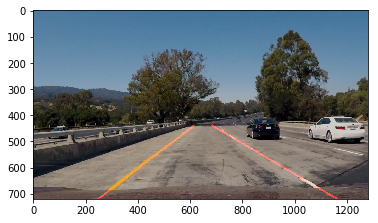

In [18]:
lines, lines_image = hough_lines(img_filtered, rho, theta, threshold, min_line_length, max_line_gap)
#colored_lines_image = np.dstack((lines_image, get_blank_image(lines_image), get_blank_image(lines_image)))
result = weighted_img(lines_image, image, α=0.8, β=1., λ=0.)

plt.imshow(result)
plt.show()
#print(lines)


In [19]:
def transformation_matrix(image, compute_pts = False ):
    if (compute_pts == True):
        
        image = undistort(image)
        bin_image = binary_img(image)
        roi_i = ROI(bin_image)
        lines, lines_image = hough_lines(roi_i, rho, theta, threshold, min_line_length, max_line_gap)
        top = image.shape[0] * 0.12
        line_right, line_left = lines 
        src = np.array([line_left[1],line_right[1],line_right[0],line_left[0]],np.float32)
        dst = np.array([[line_left[0][0], top], [line_right[0][0], top], line_right[0], line_left[0]],np.float32)
    
    else:

        src = np.array([[585, 455],
                [705, 455],
                [1100, 680],
                [250 , 700]], np.float32)

        dst = np.array([[300 ,100],
                [1000, 100],
                [1000, 720],
                [300, 720]], np.float32)

    
    # Compute the perspective transformation matrix
    Mat = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the inverse perspective transformation matrix
    M_inv = cv2.getPerspectiveTransform(dst, src)

    return Mat, M_inv


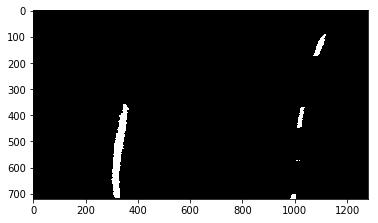

In [20]:
def transform_perspective(image, Mat):
    
     return cv2.warpPerspective(image, Mat, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

M, N = transformation_matrix(image)

P_img = transform_perspective(img_filtered, M)

plt.imshow(P_img, cmap = 'gray')
plt.show()

## Identifying lane-line pixels 

C:\Users\Hp\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:412: RuntimeWarning: divide by zero encountered in double_scalars
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])


(-0.5, 199.5, 719.5, -0.5)

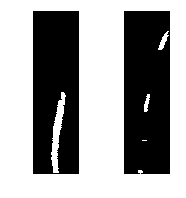

In [21]:
def get_lane_px(image):
    
    #Function returns coordinates of all pixels in left and right lane 
    
    # Calculate the coordinates of base pixels
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)

    indexes = find_peaks_cwt(histogram, np.arange(1, 550))

    # Avoid edges
    indexes = [i for i in indexes if i > image.shape[1]*0.1
                          and i < image.shape[1]*0.9
                          and max(histogram[i-50:i+50]) > 25]        
    
    
    
    base = [(indexes[0], image.shape[0]), (indexes[-1], image.shape[0])]
    
    #left and right base pixels
    left_base, right_base = base
    
    # Given base coordinates, all lane pixels are computed using a window of size 100 px

    window_size = 100
    
    right_base = right_base[0]
    
    if(right_base > window_size*2):
            window_low = right_base - window_size
    else:
            window_low = 0

    window_high = right_base + window_size
    
    # Define a region
    window_r = image[:, window_low:window_high]

    # Find the coordinates of the white pixels in this region
    #print(window_r[:100])
    right_x, right_y = np.where(window_r == 1)

    # original location
    right_y += (window_low) 

    left_base = left_base[0]
    
    if(left_base > window_size*2):
            window_low = left_base - window_size
    else:
            window_low = 0

    window_high = left_base + window_size
    
    # Define a region
    window_l = image[:, window_low:window_high]
    

    # Find the coordinates of the white pixels in this region
    left_x, left_y = np.where(window_l == 1)
     # original location
    left_y += (window_low)
    
    #np.set_printoptions(threshold=np.inf)
    #print(right_y)
    #plt.imshow(window_l)
    #plt.show()
    
    return [left_x, left_y],[right_x, right_y], left_base, right_base, window_l, window_r

a,b,c,d,e,f = get_lane_px(P_img)

plt.figure(figsize=(3,3))

plt.subplot(1, 2, 1)
plt.imshow(e,cmap = 'gray')
plt.axis('off')
#plt.xlabel('Left Lane')

plt.subplot(1, 2, 2)
plt.imshow(f,cmap = 'gray')
plt.axis('off')
#plt.xlabel('Right Lane')


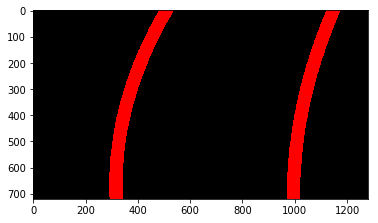

In [29]:
def draw_curves(image):
    
    blank_image = get_blank_image(image)
    
    left_px, right_px, left_base, right_base,window_l, window_r = get_lane_px(image)
    l_x, l_y = left_px
    r_x, r_y = right_px
    #print(r_x)
    
    # Second Order Polynomial to fit pixels 
    left_lane = np.polyfit(l_x, l_y, 2)
    right_lane = np.polyfit(r_x, r_y, 2)

    func_l = np.poly1d(left_lane)
    func_r = np.poly1d(right_lane)

    #x  = np.arange(0,image.shape[0])
    #x.tolist()

    x  = list(range(0,image.shape[0]))

    left = list(map(int, func_l(x)))
    right = list(map(int, func_r(x)))

    #left = np.meshgrid(x, left)
    #l_positions = np.vstack(map(np.ravel, g))
    #left_coord  = l_positions.reshape((-1,1,2))

    left_coord = np.array([[_left,_x] for _x, _left in zip(x, left)])
    right_coord = np.array([[_right,_x] for _x, _right in zip(x, right)])
    
    left_coord = left_coord.reshape((-1,1,2))
    right_coord = right_coord.reshape((-1,1,2))
    

    cv2.polylines(blank_image, np.int32([left_coord]), False, color=(255,0,0), thickness=50)

    cv2.polylines(blank_image, ([right_coord]), False, color=(255,0,0), thickness=50)
    
    #plt.imshow(blank_image)
    
    return left_coord, right_coord, left, right, left_base, right_base, blank_image

a,b,c,d,e,f,g = draw_curves(P_img)
plt.imshow(g)
plt.show()

In [30]:
def get_curvature(pixels):
    
    #Calculate the radius of curvature for the lane line
    
    left_coord, right_coord, left, right, left_base, right_base, g = pixels
    #l_x, l_y = left_px
    #r_x, r_y = right_px
    l_y = np.linspace(0, 720-1, 720)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = (30/720) # meters per pixel in y dimension
    xm_per_pix = (3.7/700) # meteres per pixel in x dimension
    left     = np.array(left)
    right     = np.array(right)
    l_y_eval = np.max(l_y)
    r_y_eval = np.max(l_y)
    
    left_fit_cr = np.polyfit(l_y*ym_per_pix, left*xm_per_pix, 2)
    right_fit_cr = np.polyfit(l_y*ym_per_pix, right*xm_per_pix, 2)
    
    left_curverad = int(((1 + (2*left_fit_cr[0]*l_y_eval + left_fit_cr[1])**2)**1.5)\
                        /np.absolute(2*left_fit_cr[0]))
    right_curverad = int(((1 + (2*right_fit_cr[0]*r_y_eval + right_fit_cr[1])**2)**1.5)\
                         /np.absolute(2*right_fit_cr[0]))

    return left_curverad, right_curverad



In [31]:
def deviation_center(image, left_base, right_base):
    
    #Calculate distance of car from centre of lane
    
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    center = (image.shape[1]//2, image.shape[0])
    
    middle = int((left_base + right_base)//2)
    
    return "{0:.2f}".format((middle - center[0]) * xm_per_pix)

## Draw Lane

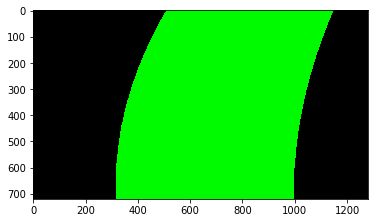

In [32]:
def draw_lanes(image):
    blank_image = get_blank_image(image)
    lane_coord = draw_curves(image)
    left_curve, right_curve = get_curvature(lane_coord)
    top = [lane_coord [0][-1], lane_coord [1][-1]]
    bottom = [lane_coord [0][0], lane_coord [1][0]]
    
    deviation = deviation_center(blank_image, lane_coord[4], lane_coord[5])
    cv2.fillPoly(blank_image, [np.concatenate((lane_coord[1], lane_coord[0], top,bottom ))], color=(0,251,0))
    return blank_image, left_curve, right_curve, deviation

a,b,c,d = draw_lanes(P_img)
plt.imshow(a ,cmap='gray')
plt.show()

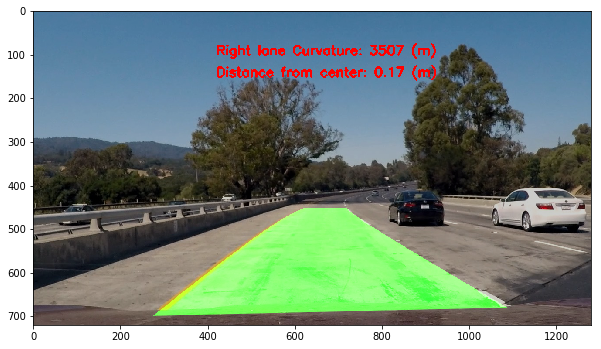

In [35]:
def lane_pipline(image):
    orig   = image
    image   = gaussian_blur(image)
    image   = undistort(image)
    image   = ROI(image)
    image   = binary_img(image)
    M, N    = transformation_matrix(image)
    image   = transform_perspective(image, M)
    lanes,left_curve, right_curve, deviation = draw_lanes(image)
    lanes   = transform_perspective(lanes, N)
    image   = weighted_img(lanes, orig, α=0.8, β=1., λ=0.)

    cv2.putText(image, "Right lane Curvature: " + str(left_curve) + " (m)", (420,100), cv2.FONT_HERSHEY_SIMPLEX, 1, 255,3)
    cv2.putText(image, "Distance from center: " + str(deviation) + " (m)", (420,150), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 3)
    
    return image
plt.figure(figsize=(10,10))
plt.imshow(lane_pipline(image))
plt.show()

In [36]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [ ]:
video = VideoFileClip("project_video.mp4")
clip = video.fl_image(lane_pipline)
%time clip.write_videofile('2p4.mp4', audio=False)

# Discussion

* The video output for the right lane is a bit jittery due to incorrect extrapolation of polymonial. That needs to fixed.

* The pipline need to be optimized as there are alot of repetitive calculations.

* Laplacian or other gradients could be used to improve line detection.